# Ground state (edge) moves

In [1]:
import numpy as np
import bisect
import matplotlib.pyplot as plt
import pimc # custom module
from scipy.stats import truncexpon

### Simulation parameters

In [2]:
# Simulation parameters
N = 2
L = N*2   # half-filling
t = 0
U = 0.5
mu = -0.1
    
# PIMC parameters
beta = 1
eta = 1/np.sqrt(L*beta)      # worm end fugacity

### Create a worldline configuration 

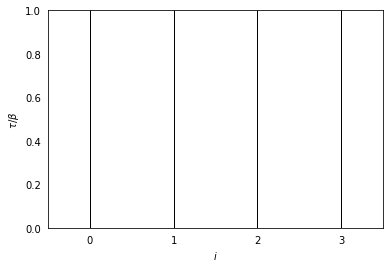

In [92]:
# Create a worldline configuration
alpha = [1,1,1,1]
data_struct = pimc.create_data_struct(alpha)
head_loc = []
tail_loc = []
pimc.view_worldlines(data_struct,beta,figure_name=None)

### Insert a worm or antiworm from $\tau=0$

tau_next: 1.0000
tau_prev: 0.0000
Insert tail


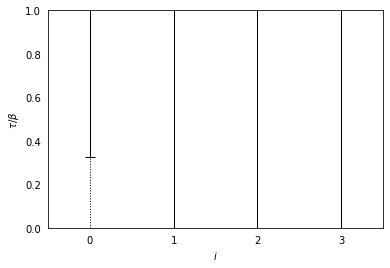

head_loc:  []
tail_loc:  [0, 1]


In [97]:
# Create a worldline configuration
alpha = [1,1,1,1]
data_struct = pimc.create_data_struct(alpha)
head_loc = []
tail_loc = []

pimc.insert_gsworm_zero(data_struct,beta,head_loc,tail_loc,U,mu,eta)
pimc.insert_gsworm_zero(data_struct,beta,head_loc,tail_loc,U,mu,eta)

pimc.view_worldlines(data_struct,beta,figure_name=None)
print("head_loc: ",head_loc)
print("tail_loc: ",tail_loc)